### Imports

In [125]:
from matplotlib_venn import venn2 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils import *

import hdbscan
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.42 ms (started: 2023-05-29 11:33:59 -05:00)


### Parameters

In [126]:
import json
  
# Opening JSON file
file = open("parameters.json")
params = json.load(file)

dir = os.path.dirname(os.getcwd())
print(dir)

method = params["method"][params["method_idx"]]
print("Method:\t\t", method)

group = params["group"][params["group_idx"]]
print("Group:\t\t", group)

subgroups = [str(k + 1) for k in range(group[1])]
print("Subgroup:\t", subgroups)

dimensions = params["dimensions"]
dimension = dimensions[0]
print("Dimensions:\t", dimensions)

/home/ealvarez/Project/GNN_Filter
Method:		 vgae
Group:		 ['WT', 5]
Subgroup:	 ['1', '2', '3', '4', '5']
Dimensions:	 [3]
time: 4.22 ms (started: 2023-05-29 11:33:59 -05:00)


### Read graphs

In [127]:
dir_ = os.path.dirname(os.getcwd())
print(dir_)

/home/ealvarez/Project/GNN_Filter
time: 775 µs (started: 2023-05-29 11:33:59 -05:00)


In [128]:
# Load dataset Groups
df1 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir_, "int1"), delimiter="|")
df2 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir_, "int2"), delimiter="|")
df3 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir_, "int3"), delimiter="|")
df4 = pd.read_csv("{}/input/Edwin_proyecto2/{}.csv".format(dir_, "int4"), delimiter="|")
# df5_ = pd.read_csv("{}/inputs/Edwin_proyecto2/{}.csv".format(dir, "int5"), delimiter="|")

""" df1 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities1"), delimiter="|")
df2 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities2"), delimiter="|")
df3 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities3"), delimiter="|")
df4 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities4"), delimiter="|")
df5_ = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities5"), delimiter="|") """

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
# print(df5_.shape)

(6245, 102)
(6245, 72)
(6245, 97)
(6245, 137)
time: 205 ms (started: 2023-05-29 11:34:00 -05:00)


In [129]:
# concat
# df_join_raw = pd.concat([df1.iloc[:,1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:], df5.iloc[:, 2:]], axis=1)
df_join_raw = pd.concat([df1.iloc[:, 1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:]], axis=1)
df_join_raw.set_index("ionMz", inplace=True)

print(df_join_raw.shape)
df_join_raw

(6245, 400)


,0001 / zwf1^ 3.4,0002 / zwf1^ 3.4,0003 / zwf1^ 3.4,0004 / zwf1^ 3.4,0005 / zwf1^ 3.4,0006 / zwf1^ 3.4,0007 / zwf1^ 3.4,0008 / zwf1^ 3.4,0009 / zwf1^ 3.4,0010 / zwf1^ 3.4,...,0951 / WT 3.4,0952 / WT 3.4,0953 / WT 3.4,0954 / WT 3.4,0955 / WT 3.4,0956 / WT 3.4,0957 / WT 3.4,0958 / WT 3.4,0959 / WT 3.4,0960 / WT 3.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1,47,508,360,675,232,59,345,346,504,...,45,817,32,307,410,716,228,187,361,952
59.0137,53182,57902,51861,62812,54291,54395,59054,52547,57544,63538,...,45747,39677,47205,38697,54320,62610,47283,49927,43632,48511
59.0291,2151,2102,2334,2864,2393,2246,2331,1954,2310,2528,...,1852,1717,1830,1660,2006,2539,2103,2276,1643,2522
59.0370,83,174,366,1134,693,464,235,479,443,691,...,225,349,185,429,186,278,364,368,115,887
59.0453,1,1,51,642,493,143,11,227,160,154,...,60,293,1,336,65,142,1,182,10,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2470,2435,2465,2727,2773,2157,2168,2623,2256,2636,...,1866,1834,1669,674,2533,1017,2983,1814,2160,1899
996.7096,3366,3241,2909,3469,3538,3010,3031,2872,2709,3601,...,1748,1419,1160,621,1758,1474,1973,1023,1769,1629
997.5542,2818,2335,1807,1679,2222,2070,2158,1835,2087,2784,...,1168,828,1162,1103,2253,1419,2306,1542,827,1433


time: 30.8 ms (started: 2023-05-29 11:34:00 -05:00)


In [130]:
# get nodes
# common_nodes = list(df_join_raw.index)
common_nodes = set([
# 59.0137,
71.0139,
# 74.0249,
85.0296,
87.0086,
88.0405,
89.0245,
# 101.0243,
# 102.0562,
# 109.0407,
115.0038,
# 117.0195,
118.051,
118.9807,
122.0247,
# 129.0192,
130.0506,
# 130.0875,
131.0355,
131.0824,
132.0303,
133.014,
135.0311,
145.0144,
145.0984,
146.0458,
147.0297,
151.0403,
152.0354,
154.062,
166.0506,
166.9758,
# 171.0302,
173.0095,
173.0454,
179.0561,
184.0021,
218.1033,
249.0552,
259.0227,
# 266.0886,
316.2857,
323.0277,
338.9889,
346.0558,
362.0509,
367.0185,
# 388.9441,
401.0173,
426.0221,
489.9937,
505.9889,
521.984,
606.0744,
664.117,
766.1076,
784.1495,
808.118,
808.118
])
common_nodes

{71.0139,
 85.0296,
 87.0086,
 88.0405,
 89.0245,
 115.0038,
 118.051,
 118.9807,
 122.0247,
 130.0506,
 131.0355,
 131.0824,
 132.0303,
 133.014,
 135.0311,
 145.0144,
 145.0984,
 146.0458,
 147.0297,
 151.0403,
 152.0354,
 154.062,
 166.0506,
 166.9758,
 173.0095,
 173.0454,
 179.0561,
 184.0021,
 218.1033,
 249.0552,
 259.0227,
 316.2857,
 323.0277,
 338.9889,
 346.0558,
 362.0509,
 367.0185,
 401.0173,
 426.0221,
 489.9937,
 505.9889,
 521.984,
 606.0744,
 664.117,
 766.1076,
 784.1495,
 808.118}

time: 6.9 ms (started: 2023-05-29 11:34:00 -05:00)


In [158]:
# GNN method STD
df_edge_embeddings_join_filter_count_weight_std_avg = pd.read_csv("{}/output_edges/edges_filter_weight_std_avg/{}_{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, method, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std_avg

G = nx.from_pandas_edgelist(df_edge_embeddings_join_filter_count_weight_std_avg, "source", "target", edge_attr=["weight"])
graph_detail(G)

nodes_gnn = set(list(G.nodes()))
print(nodes_gnn)

Num. nodes: 2279
Num. edges: 32064

{59.0291, 74.0249, 96.9602, 96.9761, 98.9721, 109.0407, 111.0086, 111.0285, 113.0246, 114.056, 115.0038, 115.9206, 116.0356, 118.0721, 116.0718, 117.0753, 117.0195, 118.051, 123.9906, 120.9537, 122.9697, 123.0007, 127.0513, 128.0572, 122.991, 130.0875, 130.1094, 123.0188, 131.0824, 132.086, 127.0761, 135.0311, 128.0355, 129.0192, 138.9357, 140.0337, 132.0521, 142.0207, 143.035, 144.0458, 145.0617, 145.0853, 147.0297, 148.0441, 148.0493, 147.0655, 147.0487, 146.0458, 146.0685, 154.9474, 155.0654, 156.9908, 157.0621, 157.9428, 156.9432, 160.0617, 161.0105, 162.056, 158.9565, 158.9393, 157.0156, 157.0256, 160.0269, 168.0277, 168.9724, 164.0717, 162.0122, 172.9579, 173.0939, 174.1078, 173.1294, 176.0406, 174.0874, 175.0612, 179.0031, 180.0666, 181.0719, 182.9479, 176.9495, 184.0021, 181.0117, 179.0153, 187.0246, 188.0264, 188.0226, 187.1087, 191.046, 192.0314, 191.0198, 190.0537, 192.0233, 196.9476, 196.9356, 198.9313, 199.1705, 200.9273, 201.1243, 202.0

In [159]:
# Greedy STD
df_edges_filter = pd.read_csv("{}/output_greedy/edges_filter/greedy_{}_edge-filter-std.csv".format(dir, group[0]))

G11 = nx.from_pandas_edgelist(df_edges_filter, "source", "target", edge_attr=["weight"])
graph_detail(G11)

nodes_std = set(list(G11.nodes()))
print(nodes_std)

Num. nodes: 4181
Num. edges: 131540

{59.0137, 59.0291, 61.9884, 74.0249, 78.9655, 78.9592, 85.0296, 88.0405, 89.0245, 94.9806, 96.9761, 96.9688, 98.9721, 96.9602, 100.9679, 100.9337, 102.0562, 102.9758, 99.9716, 109.0407, 109.0514, 111.02, 111.0285, 113.0606, 114.056, 115.0038, 115.9206, 116.0356, 116.0718, 118.051, 118.0721, 119.054, 120.9957, 122.0247, 124.0403, 120.9537, 123.0266, 122.991, 128.0355, 129.0192, 129.0385, 130.0875, 130.1094, 131.0462, 131.0824, 131.104, 132.0303, 137.0275, 137.0498, 138.029, 138.9644, 139.007, 140.0246, 141.0173, 139.0232, 145.0617, 146.0458, 147.0297, 147.0487, 147.0655, 145.0853, 148.0441, 148.0493, 146.0685, 154.062, 154.9474, 156.9432, 156.9908, 158.9393, 157.9428, 160.0617, 158.9565, 158.975, 163.0209, 164.0717, 165.0753, 161.0105, 161.0456, 168.0277, 162.0122, 162.056, 165.0405, 172.9579, 173.0939, 173.1042, 173.1294, 174.9538, 175.0612, 175.9534, 176.0406, 176.9495, 178.9454, 178.9606, 180.941, 184.0021, 180.0666, 177.9493, 187.0246, 188.0264, 

In [160]:
# Greedy STD-ANOVA
df_edges_filter = pd.read_csv("{}/output_greedy/edges_filter/greedy_{}_edge-filter-std-anova.csv".format(dir, group[0]))

G12 = nx.from_pandas_edgelist(df_edges_filter, "source", "target", edge_attr=["weight"])
graph_detail(G12)

nodes_std_anova = set(list(G12.nodes()))
print(nodes_std_anova)

Num. nodes: 1452
Num. edges: 11868

{61.9884, 122.991, 123.036, 123.9906, 123.0007, 123.0188, 124.9664, 140.9331, 141.0535, 140.984, 150.041, 150.0557, 156.012, 156.029, 159.9762, 160.969, 159.9582, 161.0354, 162.9323, 162.9687, 166.9559, 166.9758, 166.9962, 168.9724, 167.9759, 169.0103, 169.0494, 170.0109, 170.0324, 171.0302, 171.0467, 172.0978, 172.1046, 174.041, 174.0561, 174.9907, 175.0068, 175.0245, 175.0364, 181.0517, 181.0975, 181.1089, 184.8978, 189.0756, 184.9337, 184.9456, 184.986, 185.0113, 185.0568, 186.9765, 187.0071, 188.986, 189.0402, 190.9641, 191.0803, 195.0143, 195.0288, 198.8978, 199.0186, 199.0424, 199.0596, 207.0669, 208.9922, 209.0946, 209.0324, 209.0087, 210.0021, 210.0762, 210.088, 210.1129, 210.1487, 211.0285, 211.134, 211.1698, 212.9456, 212.9918, 213.0491, 214.0767, 221.1547, 225.0241, 225.007, 227.0648, 225.0404, 226.9226, 227.004, 230.0645, 230.0465, 232.0615, 234.9807, 232.0831, 232.9421, 232.9908, 233.0091, 233.0273, 233.0456, 232.9745, 233.0652, 234.9504

In [161]:
# Greedy ANOVA
df_edges_filter = pd.read_csv("{}/output_greedy/edges_filter/greedy_{}_edge-filter-anova.csv".format(dir, group[0]))

G21 = nx.from_pandas_edgelist(df_edges_filter, "source", "target")
graph_detail(G21)

nodes_anova = set(list(G21.nodes()))
print(nodes_anova)

Num. nodes: 1452
Num. edges: 11970

{61.9884, 122.991, 123.0188, 123.036, 123.0007, 123.9906, 124.9664, 140.984, 141.0535, 140.9331, 150.041, 150.0557, 156.012, 156.029, 159.9582, 159.9762, 161.0354, 160.969, 162.9687, 162.9323, 166.9758, 166.9962, 166.9559, 168.9724, 167.9759, 169.0103, 169.0494, 170.0324, 170.0109, 172.0978, 172.1046, 174.9907, 175.0068, 175.0972, 175.0245, 175.0364, 174.041, 174.0561, 181.0975, 181.1089, 181.0517, 184.8978, 188.986, 184.9337, 184.9456, 184.986, 185.0113, 185.0568, 185.0928, 187.0071, 187.0611, 191.0688, 191.0803, 191.1069, 194.9633, 194.9891, 195.0288, 195.0143, 196.0886, 199.0186, 199.0596, 199.0736, 200.8932, 208.0279, 208.0433, 208.0153, 210.088, 210.1129, 210.0762, 210.1487, 210.0021, 210.0251, 212.9918, 212.9456, 212.9031, 213.0145, 213.0609, 214.0767, 221.1547, 225.007, 225.0404, 225.0241, 227.0648, 226.9226, 227.004, 230.0645, 232.9421, 233.0456, 233.0273, 233.0091, 236.1391, 236.0785, 236.0902, 232.9908, 233.0652, 232.9745, 233.1019, 234.950

In [162]:
# Greedy ANOVA-STD
df_edges_filter = pd.read_csv("{}/output_greedy/edges_filter/greedy_{}_edge-filter-anova-std.csv".format(dir, group[0]))

G22 = nx.from_pandas_edgelist(df_edges_filter, "source", "target", edge_attr=["weight"])
graph_detail(G22)

nodes_anova_std = set(list(G22.nodes()))
print(nodes_anova_std)

Num. nodes: 1452
Num. edges: 11868

{61.9884, 122.991, 123.0188, 123.036, 123.9906, 123.0007, 124.9664, 140.9331, 141.0535, 140.984, 150.041, 150.0557, 156.012, 156.029, 159.9582, 159.9762, 160.969, 161.0354, 162.9323, 162.9687, 166.9559, 166.9758, 167.9759, 168.9724, 169.0103, 170.0109, 171.0302, 166.9962, 174.041, 175.0068, 169.0494, 170.0324, 171.0467, 172.0978, 172.1046, 181.0975, 181.1089, 181.0517, 184.8978, 184.9337, 184.9456, 184.986, 185.0113, 185.0568, 185.0928, 185.0274, 185.0449, 185.0817, 186.9765, 187.0071, 187.0611, 188.986, 189.0402, 190.9641, 191.0688, 194.9633, 194.9891, 195.0143, 195.0288, 196.0886, 198.8978, 207.1392, 207.9219, 208.0153, 208.0433, 208.0613, 208.0815, 208.0983, 208.1385, 208.9922, 209.0639, 209.0324, 209.0946, 210.0251, 211.04, 212.0742, 213.0491, 214.0767, 221.1547, 225.007, 225.0241, 227.0648, 225.0404, 226.9226, 227.004, 230.0465, 230.0645, 232.0615, 232.0831, 232.9421, 232.9908, 233.0091, 233.0273, 233.0456, 232.9745, 233.0652, 233.1019, 234.9504

In [163]:
def ope_set(s1, s2):
    a = s1 & s2
    b = s1 - s2
    c = s2 - s1
    return a, b, c


time: 838 µs (started: 2023-05-29 11:46:30 -05:00)


---

### Get common edges

In [164]:
len(common_nodes)

47

time: 4.33 ms (started: 2023-05-29 11:46:36 -05:00)


29 18 2250


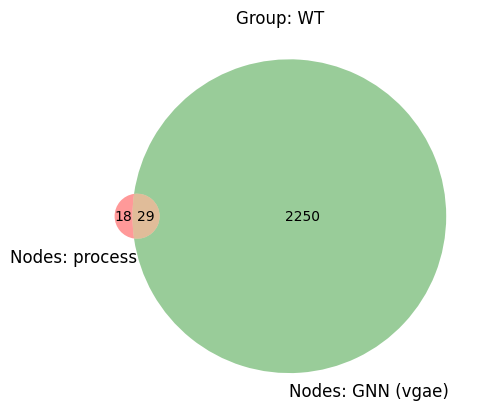

time: 93.9 ms (started: 2023-05-29 11:46:43 -05:00)


In [165]:
a, b, c = ope_set(common_nodes, nodes_gnn)
print(len(a),len(b), len(c))
venn2(subsets = (len(b), len(c), len(a)), set_labels=("Nodes: process", "Nodes: GNN ({})".format(method)))
plt.title("Group: {}".format(group[0]))
plt.show()

39 8 4142


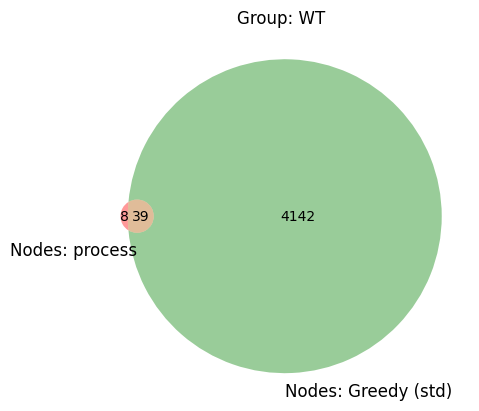

time: 68.2 ms (started: 2023-05-29 11:46:58 -05:00)


In [166]:
a, b, c = ope_set(common_nodes, nodes_std)
print(len(a),len(b), len(c))
venn2(subsets = (len(b), len(c), len(a)), set_labels=("Nodes: process", "Nodes: Greedy (std)"))
plt.title("Group: {}".format(group[0]))
plt.show()

2 45 1450


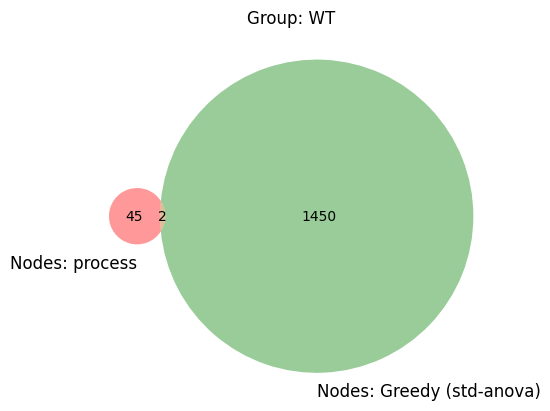

time: 74.3 ms (started: 2023-05-29 11:47:39 -05:00)


In [167]:
a, b, c = ope_set(common_nodes, nodes_std_anova)
print(len(a),len(b), len(c))
venn2(subsets = (len(b), len(c), len(a)), set_labels=("Nodes: process", "Nodes: Greedy (std-anova)"))
plt.title("Group: {}".format(group[0]))
plt.show()

2 45 1450


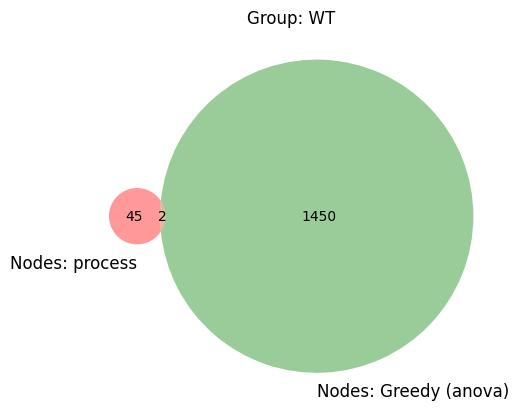

time: 73.7 ms (started: 2023-05-29 11:48:25 -05:00)


In [169]:
a, b, c = ope_set(common_nodes, nodes_anova)
print(len(a),len(b), len(c))
venn2(subsets = (len(b), len(c), len(a)), set_labels=("Nodes: process", "Nodes: Greedy (anova)"))
plt.title("Group: {}".format(group[0]))
plt.show()

2 45 1450


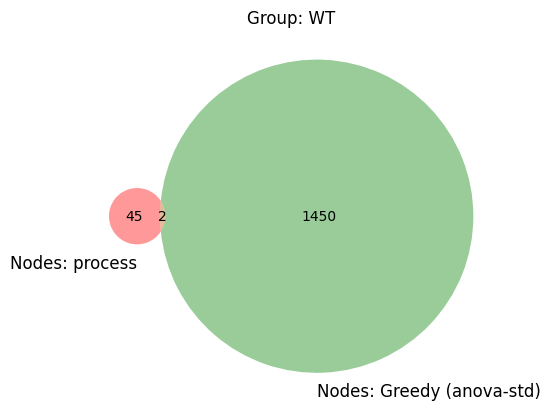

time: 76.1 ms (started: 2023-05-29 11:48:33 -05:00)


In [170]:
a, b, c = ope_set(common_nodes, nodes_anova_std)
print(len(a),len(b), len(c))
venn2(subsets = (len(b), len(c), len(a)), set_labels=("Nodes: process", "Nodes: Greedy (anova-std)"))
plt.title("Group: {}".format(group[0]))
plt.show()